<a href="https://colab.research.google.com/github/FOwen123/Text-Generation-Model/blob/main/DeepLearning_Midterm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
pip install tensorflow

In [33]:
import random
import pickle
import heapq

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Activation, Embedding, Dropout
from tensorflow.keras.optimizers import RMSprop

# Pre Processing

In [34]:
text_df = pd.read_csv("fake_or_real_news.csv")
text = list(text_df.text.values)
joined_text = " ".join(text)

with open("joined_text.txt", "w", encoding="utf-8") as f:
    f.write(joined_text)

In [35]:
partial_text = joined_text[:1000000]

In [36]:
tokenizer = RegexpTokenizer(r"\w+")
tokens = tokenizer.tokenize(partial_text.lower())

In [37]:
unique_tokens = np.unique(tokens)
unique_token_index = {token: index for index, token in enumerate(unique_tokens)}

In [38]:
n_words = 50
input_words = []
next_word = []

for i in range(len(tokens) - n_words):
    input_words.append(tokens[i:i + n_words])
    next_word.append(tokens[i + n_words])

In [39]:
# 1. Create X as a 2D array of integers
# Shape: (num_samples, n_words)
X = np.zeros((len(input_words), n_words), dtype=np.int32)

# 2. Create y as a 1D array of integers
# Shape: (num_samples,)
y = np.zeros((len(input_words),), dtype=np.int32)

In [40]:
for i, words in enumerate(input_words):
    for j, word in enumerate(words):
        X[i, j] = unique_token_index[word]
    y[i] = unique_token_index[next_word[i]]

#Model Training

In [41]:
from tensorflow.keras import layers

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
        super().__init__(**kwargs)
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training=None):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions


In [42]:
embedding_dim = 100 # Embedding dimension
num_heads = 4       # Number of attention heads
ff_dim = 128         # Hidden layer size in feed forward network inside transformer

# --- NEW TRANSFORMER MODEL ---
inputs = layers.Input(shape=(n_words,))
embedding_layer = TokenAndPositionEmbedding(n_words, len(unique_tokens), embedding_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embedding_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(512, activation="relu")(x)
outputs = layers.Dense(len(unique_tokens), activation="softmax")(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

# --- OLD LSTM MODEL (COMMENTED) ---
# embedding_dim = 100 # Embedding dimension
#
# model = Sequential()
#
# # 1. The 'Embedding' layer
# # Takes integer inputs (vocab size 15000
# # Turns them into 100-dimension vectors.
# model.add(Embedding(input_dim=len(unique_tokens),
#                     output_dim=embedding_dim,
#                     input_length=n_words))
#
# # 2. The LSTM layer
# # [batch_size, n_words, embedding_dim]
# model.add(LSTM(128, return_sequences=True))
# model.add(LSTM(128))
# model.add(Dense(len(unique_tokens), activation="softmax"))

In [43]:
optimizer = RMSprop(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X, y, batch_size=128, epochs=10, shuffle=True).history

Epoch 1/10
1326/1326 ━━━━━━━━━━━━━━━━━━━━ 705s 529ms/step - accuracy: 0.0584 - loss: 7.3872
Epoch 2/10
1326/1326 ━━━━━━━━━━━━━━━━━━━━ 668s 504ms/step - accuracy: 0.0781 - loss: 6.8475
Epoch 3/10
1326/1326 ━━━━━━━━━━━━━━━━━━━━ 682s 504ms/step - accuracy: 0.0969 - loss: 6.5662
Epoch 4/10
1326/1326 ━━━━━━━━━━━━━━━━━━━━ 669s 494ms/step - accuracy: 0.1232 - loss: 6.2096
Epoch 5/10
1326/1326 ━━━━━━━━━━━━━━━━━━━━ 670s 505ms/step - accuracy: 0.1595 - loss: 5.8553
Epoch 6/10
1326/1326 ━━━━━━━━━━━━━━━━━━━━ 664s 501ms/step - accuracy: 0.2136 - loss: 5.5082
Epoch 7/10
1326/1326 ━━━━━━━━━━━━━━━━━━━━ 685s 503ms/step - accuracy: 0.2642 - loss: 5.2507
Epoch 8/10
1326/1326 ━━━━━━━━━━━━━━━━━━━━ 662s 499ms/step - accuracy: 0.3118 - loss: 5.0351
Epoch 9/10
1326/1326 ━━━━━━━━━━━━━━━━━━━━ 693s 508ms/step - accuracy: 0.3613 - loss: 4.8017
Epoch 10/10
1326/1326 ━━━━━━━━━━━━━━━━━━━━ 677s 511ms/step - accuracy: 0.4036 - loss: 4.6139


In [44]:
model.save("text_gen_model.h5")
with open("history_model.p", "wb") as f:
  pickle.dump(history, f)

In [45]:
model = load_model("text_gen_model.h5", custom_objects={"TokenAndPositionEmbedding": TokenAndPositionEmbedding, "TransformerBlock": TransformerBlock})
history = pickle.load(open("history_model.p", "rb"))

In [46]:
def predict_next_word(input_text, n_best):
  """
  Prepares input text as integer indices for the embedding model
  and predicts the next word.
  """
  input_text = input_text.lower()
  # 1. Create X as a 2D array of integers
  X = np.zeros((1, n_words), dtype=np.int32)

  # 2. Tokenize and fill the array with integer indices
  words = input_text.split()
  for i, word in enumerate(words):
      # Stop if we exceed the sequence length
      if i >= n_words:
          break
      X[0, i] = unique_token_index.get(word, 0)

  # 3. Predict using the integer-based input
  predictions = model.predict(X)[0]

  # 4. Return the indices of the 'n_best' most likely words
  return np.argpartition(predictions, -n_best)[-n_best:]

In [47]:
possible = predict_next_word("I will have to look into this thing because I", 5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


In [48]:
for idx in possible:
  print(unique_tokens[idx])

service
scalia
countries
force
words


In [49]:
def generate_text(input_text, text_length, creativity=3):
  word_sequence = input_text.split()
  current = 0
  for _ in range(text_length):
    # Simple sliding window
    sub_sequence = " ".join(tokenizer.tokenize(" ".join(word_sequence).lower())[current:current+n_words])
    try:
        # Get the indices of the top 'creativity' predictions
        # Similar to top-k sampling in LLMs
        possible_indices = predict_next_word(sub_sequence, creativity)

        # Randomly choose one of those indices
        chosen_index = random.choice(possible_indices)

        # Get the actual word from the index
        choice = unique_tokens[chosen_index]
    except Exception as e:
        print(f"Error during prediction: {e}. Choosing random word.")
        choice = random.choice(unique_tokens)
    word_sequence.append(choice)
    current += 1
  return " ".join(word_sequence)

In [50]:
for idx in predict_next_word("The president will most likely not be there to help", 5):
    print(unique_tokens[idx])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
mistry
revealed
24
sources
adams


In [53]:
generate_text("The president of the Asia University announced yesterday that he", 100, 10)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━

'The president of the Asia University announced yesterday that he mistry photos adams bailout pic levels due license identity photos courtesy style revealed unhrc mistry regional license dad regional opened license license license levels analytical sources scalia photos photos dad license rt image due cyrus dad helping opened license aggression photos courtesy works family sources mistry helping analytical pole photos license regional style opened covert mistry due adams regional digital pole courtesy relied license license contributor dad regional license mistry contributor analytical cyrus unhrc unhrc dad courtesy cyrus image relied regional identity tim license photos license unhrc photos dad photos mistry pole contributor cyrus football opened mistry dad license opened'

# Summary

This project details the implementation of a **causal language model** based on a **Recurrent Neural Network (RNN)** architecture. The model utilizes an `Embedding` layer followed by stacked `LSTM` layers to process fixed-length (10-word) sequences from a news corpus. Its objective is to predict a probability distribution for the subsequent word, from which a selection is made using a **Top-k sampling** strategy.

This foundational approach serves as a basis for modern Large Language Models (LLMs), which employ an evolved architecture—the **Transformer**—to achieve similar goals. Whereas this project's LSTM processes information sequentially, Transformers utilize a **self-attention** mechanism to weigh the influence of all tokens in parallel. This mechanism enables a far more sophisticated capture of complex, long-range contextual dependencies, which, when combined with internet-scale training data and advanced sampling (like **Top-p sampling**), allows modern LLMs to generate text of significantly higher coherence and quality.

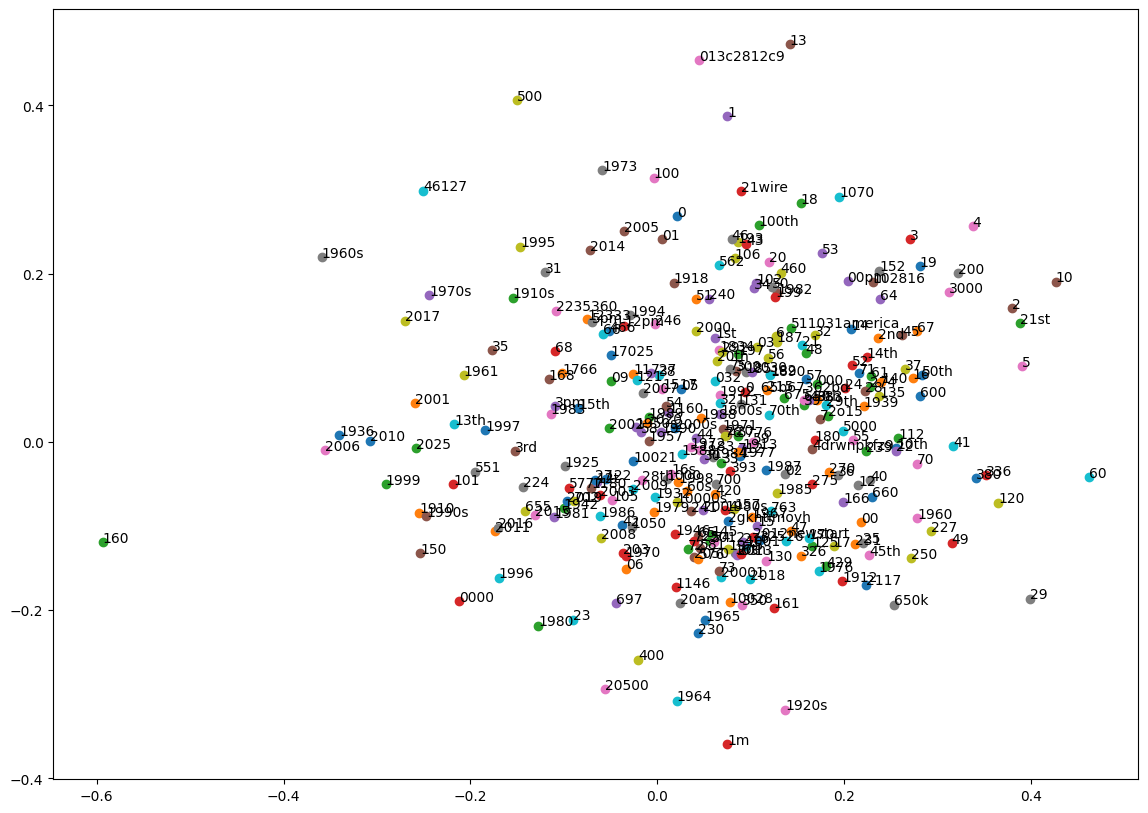

In [52]:
# --- PCA VISUALIZATION ---
from sklearn.decomposition import PCA

# Get the embedding layer weights
# Note: In the Transformer model, embeddings are in the TokenAndPositionEmbedding layer
# We need to access it by name or index. Since we built it functionally, let's try to find it.
try:
    # Assuming the first layer after input is TokenAndPositionEmbedding
    # and it has an attribute 'token_emb'
    embedding_layer = model.layers[1]
    weights = embedding_layer.token_emb.get_weights()[0]
except:
    print("Could not extract weights directly. Make sure the model is built.")
    weights = None

if weights is not None:
    # Reduce dimensions to 2D
    pca = PCA(n_components=2)
    results = pca.fit_transform(weights)

    # Plot a subset of words
    plt.figure(figsize=(14, 10))
    # Plot just the first 300 words to avoid clutter
    for i, word in enumerate(unique_tokens[:300]):
        plt.scatter(results[i, 0], results[i, 1])
        plt.annotate(word, xy=(results[i, 0], results[i, 1]))
    plt.show()
